### Evotuning (UniRep)

### 1900-unit mLSTM

In [1]:
USE_FULL_1900_DIM_MODEL = True # if True use 1900 dimensional model, else use 64 dimensional one.

## Setup

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
import numpy as np
sys.path.append('/Users/aniton/Documents/GitHub/UniRep')
# Set seeds
tf.random.set_random_seed(42)
np.random.seed(42)

if USE_FULL_1900_DIM_MODEL:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/1900_weights/ 1900_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler1900 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./1900_weights"
    
else:
    # Sync relevant weight files
    !aws s3 sync --no-sign-request --quiet s3://unirep-public/64_weights/ 64_weights/
    
    # Import the mLSTM babbler model
    from unirep import babbler64 as babbler
    
    # Where model weights are stored.
    MODEL_WEIGHT_PATH = "./64_weights"

Instructions for updating:
non-resource variables are not supported in the long term


## Data formatting and management

In [3]:
from tf_slim.layers import layers as _layers
batch_size = 12
b = babbler(batch_size=batch_size, model_path=MODEL_WEIGHT_PATH)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.random.categorical` instead.


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '



Форматирование: аминокислота -> числовое значение  (formatted.txt)

In [4]:
# Before you can train your model, 
with open("gpcr1.txt", "r") as source:
    with open("formatted.txt", "w") as destination:
        for i,seq in enumerate(source):
            seq = seq.strip()
            if b.is_valid_seq(seq): 
                formatted = ",".join(map(str,b.format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

В файле gpcr.txt: <br>
    <li> 5-hydroxytryptamine receptor 1B
    <li> 5-hydroxytryptamine receptor 7
     <li> Adhesion G protein-coupled receptor L1
     <li> G-protein-coupled receptor 157
     <li> Adhesion G protein-coupled receptor L4
       <li>   5-hydroxytryptamine receptor 1F
         <li>        Type-2 angiotensin II receptor
          <li>      Adhesion G protein-coupled receptor E1
            <li>     Extracellular calcium-sensing receptor

#### Shuffling the sequences 

In [5]:
bucket_op = b.bucket_batch_pad("formatted.txt", interval=1000) 

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch = sess.run(bucket_op)
    
print(batch)
print(batch.shape)

[[24  6  6 ...  0  0  0]
 [24  1  5 ...  0  0  0]
 [24  1  2 ...  4  8 13]
 ...
 [24  6  6 ...  0  0  0]
 [24  1  2 ...  4  8 13]
 [24  1  5 ...  0  0  0]]
(12, 887)



#### Training a top model and a top model + mLSTM.

A basic feed-forward network as a top model by regression with MSE loss, and the Adam optimizer. <br> Steps:

1.  Defining a loss function.


In [7]:
final_hidden, x_placeholder, batch_size_placeholder, seq_length_placeholder, initial_state_placeholder = (
    b.get_rep_ops())

In [8]:
from tf_slim.layers import layers as _layers
y_placeholder = tf.placeholder(tf.float32, shape=[None,1], name="y")
initializer = tf.initializers.glorot_uniform()

with tf.variable_scope("top"):
    prediction = _layers.fully_connected(
        final_hidden, 1, activation_fn=None, 
        weights_initializer=initializer,
        biases_initializer=tf.zeros_initializer()
    )

loss = tf.losses.mean_squared_error(y_placeholder, prediction)


2.  Defining an optimizer that's only optimizing variables in the top model.

3.  Minimizing the loss inside of a TensorFlow session

In [9]:
learning_rate=.001
top_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="top")
optimizer = tf.train.AdamOptimizer(learning_rate)
top_only_step_op = optimizer.minimize(loss, var_list=top_variables)
all_step_op = optimizer.minimize(loss)

In [10]:
def nonpad_len(batch):
    nonzero = batch > 0
    lengths = np.sum(nonzero, axis=1)
    return lengths

nonpad_len(batch)

array([390, 367, 887, 480, 691, 364, 364, 691, 480, 390, 887, 367])

predicting the number 42 just optimizing the top model.

In [11]:
y = [[42]]*batch_size
num_iters = 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_iters):
        batch = sess.run(bucket_op)
        length = nonpad_len(batch)
        loss_, __, = sess.run([loss, top_only_step_op],
                feed_dict={
                     x_placeholder: batch,
                     y_placeholder: y,
                     batch_size_placeholder: batch_size,
                     seq_length_placeholder:length,
                     initial_state_placeholder:b._zero_state
                }
        )
                  
        print("Iteration {0}: {1}".format(i, loss_))

Iteration 0: 1759.3587646484375
Iteration 1: 1740.8365478515625
Iteration 2: 1727.8863525390625
Iteration 3: 1712.81396484375
Iteration 4: 1707.2603759765625
Iteration 5: 1682.9117431640625
Iteration 6: 1684.8509521484375
Iteration 7: 1654.2928466796875
Iteration 8: 1662.0953369140625
Iteration 9: 1626.4605712890625


#### top model + mLSTM

In [14]:
y = [[42]]*batch_size
num_iters = 10
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(num_iters):
        batch = sess.run(bucket_op)
        length = nonpad_len(batch)
        loss_, __, = sess.run([loss, all_step_op],
                feed_dict={
                     x_placeholder: batch,
                     y_placeholder: y,
                     batch_size_placeholder: batch_size,
                     seq_length_placeholder:length,
                     initial_state_placeholder:b._zero_state
                }
        )
        
        print("Iteration {0}: {1}".format(i,loss_))

Iteration 0: 1760.6185302734375
Iteration 1: 1617.3974609375
Iteration 2: 1706.32568359375
Iteration 3: 1461.4375
Iteration 4: 1303.4017333984375
Iteration 5: 1411.4010009765625
Iteration 6: 1005.8563842773438
Iteration 7: 887.9618530273438
Iteration 8: 1043.76904296875
Iteration 9: 614.5014038085938


### A bit of UniRep-analysis

#### Given a short seed sequence, allow the babbler to babble a while and see what comes out: <br>
Let's try ADGRL1_HUMAN


In [12]:
seed = """
MARLAAVLWNLCVTAVLVTSATQGLSRAGLPFGLMRRELACEGYPIELRCPGSDVIMVENANYGRTDDKICDADPFQMENVQCYLPDAFKIMSQRCNNRTQCVVVAGSDAFPDPCPGTYKYLEVQYDCVPYKVEQKVFVCPGTLQKVLEPTSTHESEHQSGAWCKDPLQAGDRIYVMPWIPYRTDTLTEYASWEDYVAARHTTTYRLPNRVDGTGFVVYDGAVFYNKERTRNIVKYDLRTRIKSGETVINTANYHDTSPYRWGGKTDIDLAVDENGLWVIYATEGNNGRLVVSQLNPYTLRFEGTWETGYDKRSASNAFMVCGVLYVLRSVYVDDDSEAAGNRVDYAFNTNANREEPVSLTFPNPYQFISSVDYNPRDNQLYVWNNYFVVRYSLEFGPPDPSAGPATSPPLSTTTTARPTPLTSTASPAATTPLRRAPLTTHPVGAINQLGPDLPPATAPVPSTRRPPAPNLHVSPELFCEPREVRRVQWPATQQGMLVERPCPKGTRGIASFQCLPALGLWNPRGPDLSNCTSPWVNQVAQKIKSGENAANIASELARHTRGSIYAGDVSSSVKLMEQLLDILDAQLQALRPIERESAGKNYNKMHKRERTCKDYIKAVVETVDNLLRPEALESWKDMNATEQVHTATMLLDVLEEGAFLLADNVREPARFLAAKENVVLEVTVLNTEGQVQELVFPQEEYPRKNSIQLSAKTIKQNSRNGVVKVVFILYNNLGLFLSTENATVKLAGEAGPGGPGGASLVVNSQVIAASINKESSRVFLMDPVIFTVAHLEDKNHFNANCSFWNYSERSMLGYWSTQGCRLVESNKTHTTCACSHLTNFAVLMAHREIYQGRINELLLSVITWVGIVISLVCLAICISTFCFLRGLQTDRNTIHKNLCINLFLAELLFLVGIDKTQYEIACPIFAGLLHYFFLAAFSWLCLEGVHLYLLLVEVFESEYSRTKYYYLGGYCFPALVVGIAAAIDYRSYGTEKACWLRVDNYFIWSFIGPVSFVIVVNLVFLMVTLHKMIRSSSVLKPDSSRLDNIKSWALGAIALLFLLGLTWAFGLLFINKESVVMAYLFTTFNAFQGVFIFVFHCALQKKVHKEYSKCLRHSYCCIRSPPGGTHGSLKTSAMRSNTRYYTGTQSRIRRMWNDTVRKQTESSFMAGDINSTPTLNRGTMGNHLLTNPVLQPRGGTSPYNTLIAESVGFNPSSPPVFNSPGSYREPKHPLGGREACGMDTLPLNGNFNNSYSLRSGDFPPGDGGPEPPRGRNLADAAAFEKMIISELVHNNLRGSSSAAKGPPPPEPPVPPVPGGGGEEEAGGPGGADRAEIELLYKALEEPLLLPRAQSVLYQSDLDESESCTAEDGATSRPLSSPPGRDSLYASGANLRDSPSYPDSSPEGPSEALPPPPPAPPGPPEIYYTSRPPALVARNPLQGYYQVRRPSHEGYLAAPGLEGPGPDGDGQMQLVTSL
""".replace("\n","")
seed

'MARLAAVLWNLCVTAVLVTSATQGLSRAGLPFGLMRRELACEGYPIELRCPGSDVIMVENANYGRTDDKICDADPFQMENVQCYLPDAFKIMSQRCNNRTQCVVVAGSDAFPDPCPGTYKYLEVQYDCVPYKVEQKVFVCPGTLQKVLEPTSTHESEHQSGAWCKDPLQAGDRIYVMPWIPYRTDTLTEYASWEDYVAARHTTTYRLPNRVDGTGFVVYDGAVFYNKERTRNIVKYDLRTRIKSGETVINTANYHDTSPYRWGGKTDIDLAVDENGLWVIYATEGNNGRLVVSQLNPYTLRFEGTWETGYDKRSASNAFMVCGVLYVLRSVYVDDDSEAAGNRVDYAFNTNANREEPVSLTFPNPYQFISSVDYNPRDNQLYVWNNYFVVRYSLEFGPPDPSAGPATSPPLSTTTTARPTPLTSTASPAATTPLRRAPLTTHPVGAINQLGPDLPPATAPVPSTRRPPAPNLHVSPELFCEPREVRRVQWPATQQGMLVERPCPKGTRGIASFQCLPALGLWNPRGPDLSNCTSPWVNQVAQKIKSGENAANIASELARHTRGSIYAGDVSSSVKLMEQLLDILDAQLQALRPIERESAGKNYNKMHKRERTCKDYIKAVVETVDNLLRPEALESWKDMNATEQVHTATMLLDVLEEGAFLLADNVREPARFLAAKENVVLEVTVLNTEGQVQELVFPQEEYPRKNSIQLSAKTIKQNSRNGVVKVVFILYNNLGLFLSTENATVKLAGEAGPGGPGGASLVVNSQVIAASINKESSRVFLMDPVIFTVAHLEDKNHFNANCSFWNYSERSMLGYWSTQGCRLVESNKTHTTCACSHLTNFAVLMAHREIYQGRINELLLSVITWVGIVISLVCLAICISTFCFLRGLQTDRNTIHKNLCINLFLAELLFLVGIDKTQYEIACPIFAGLLHYFFLAAFSWLCLEGVHLYLLLVEVFESEYSRTKYYYLGGYCFPALVVGIAAAIDYRSYGTEKACWLRV

In [23]:
babbled = b.get_babble(seed=seed[:15], length=400, temp=.8)
print(babbled)
babbled.split('stop')[0]

MARLAAVLWNLCVTARLSLGQRPCPLYRLSGSRLLLRVLQQWPEGQMLLSEGGRPGALLGVGLSstopLWQLVGNSREPFstopFTGTLLLVFHMRVLDDSSSNYWAARISISYPSSARLAFTVLRKSNVFPINSKGVLQPTSSLSFLSLIPFSLPPFAAVLPLPSPSPSSALSSSVSPSPSSPSPPFPSSSSSSPPPSDPSPLISSSPFLFVLLSRFSSSISLSLSSSLSSSSSPSSSSSSLFSSSLLFLLLSSSSSPFLSYSLLLSSSPLLPSSFFILFPFLSLSFFSSSSSLPFLLSSPFLFSSSLSSSFLLPSSFLSSSPFSSISSSSSLFSFTSSSFSSSSSFSSSSSSSSFLSLLSPFLLLSSLLPSSLSFSSSSLFSFSPFLSSHLSSSCLFSSSSFLS


'MARLAAVLWNLCVTARLSLGQRPCPLYRLSGSRLLLRVLQQWPEGQMLLSEGGRPGALLGVGLS'

#### The authors homology modeled the received amino acid sequence with iTasser Server, the first model selected, and structurally aligned with the source PDB structure

#### An example with a glucose ABC transporter (sequence from PDB:1oxx): seed residues are in red 

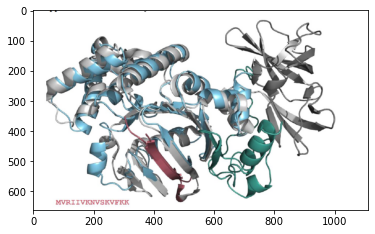

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('/Users/aniton/Desktop/bbl1oxx.png'))